In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import numpy
import pandas as pd
import rdkit
print(rdkit.__version__)
import time
print(time.asctime())
import pylab
%pylab inline

2019.09.1dev1
Mon May 27 11:06:34 2019
Populating the interactive namespace from numpy and matplotlib


/other_linux/home/glandrum/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
from collections import namedtuple
data_tuple = namedtuple('data_tuple',('source','type','assay_id','frac_delta','act1','act2',
                                      'molregno1','molregno2','smiles1','smiles2'))

In [3]:
import psycopg2
cn = psycopg2.connect(host='localhost',dbname='chembl_24')
curs = cn.cursor()

In [4]:
curs.execute('''drop table if exists cellular_assays;
    drop table if exists tissue_assays;
    drop table if exists tox_assays; 
    drop table if exists adme_assays;''')

In [5]:
curs.execute('''select assays.* into temporary table cellular_assays from assays
      join bioassay_ontology on (bao_format=bao_id) where label='cell-based format';
    select assays.* into temporary table tissue_assays from assays
      join bioassay_ontology on (bao_format=bao_id) where label='tissue-based format';
    select assays.* into temporary table tox_assays from assays
      where assay_type='T';
    select assays.* into temporary table adme_assays from assays
      where assay_type='A';
''')

In [6]:
curs.execute('''select standard_type,count(distinct(molregno)) mol_count,count(distinct(assay_id)) assay_count from
      cellular_assays
      join activities using (assay_id)
      where standard_value is not null
      group by standard_type
      order by mol_count desc\
      limit 10;''')
curs.fetchall()

[('IC50', 282376, 60522),
 ('Potency', 159376, 86),
 ('Inhibition', 124547, 13029),
 ('EC50', 86842, 11718),
 ('GI50', 60762, 26799),
 ('Ki', 59263, 10063),
 ('Activity', 44883, 51706),
 ('CC50', 38501, 3386),
 ('AC50', 16151, 330),
 ('Ratio IC50', 13913, 4475)]

In [7]:
curs.execute('''select standard_type,count(distinct(molregno)) mol_count,count(distinct(assay_id)) assay_count from
      tissue_assays
      join activities using (assay_id)
      where standard_value is not null
      group by standard_type
      order by mol_count desc\
      limit 10;''')
curs.fetchall()

[('IC50', 20025, 2919),
 ('Ki', 12073, 1803),
 ('Inhibition', 3921, 1277),
 ('Activity', 3561, 2012),
 ('Kd', 2815, 632),
 ('EC50', 2318, 494),
 ('Ratio', 1532, 729),
 ('T1/2', 1449, 400),
 ('Hepatotoxicity (granulomatous hepatitis)', 1214, 1),
 ('Hepatotoxicity (choleostasis)', 1214, 1)]

In [8]:
curs.execute('''select standard_type,count(distinct(molregno)) mol_count,count(distinct(assay_id)) assay_count from
      tox_assays
      join activities using (assay_id)
      where standard_value is not null
      group by standard_type
      order by mol_count desc\
      limit 10;''')
curs.fetchall()

[('Inhibition', 68938, 41),
 ('CC50', 6482, 87),
 ('IC50', 5254, 191),
 ('Hepatotoxicity (granulomatous hepatitis)', 1214, 1),
 ('Hepatotoxicity (cirrhosis)', 1214, 1),
 ('Hepatotoxicity (cytolytic)', 1214, 1),
 ('Hepatotoxicity (choleostasis)', 1214, 1),
 ('Hepatotoxicity (acute)', 1214, 2),
 ('Hepatotoxicity (benign tumour)', 1214, 1),
 ('Hepatotoxicity (association with vascular disease)', 1214, 1)]

In [9]:
curs.execute('''select standard_type,count(distinct(molregno)) mol_count,count(distinct(assay_id)) assay_count from
      adme_assays
      join activities using (assay_id)
      where standard_value is not null
      group by standard_type
      order by mol_count desc\
      limit 10;''')
curs.fetchall()

[('IC50', 36246, 9161),
 ('T1/2', 25694, 15542),
 ('CC50', 23581, 2336),
 ('CL', 23212, 11062),
 ('Activity', 17660, 13102),
 ('F', 13720, 8903),
 ('AUC', 12022, 11741),
 ('Cmax', 8688, 8596),
 ('Potency', 8545, 7),
 ('Ratio', 7963, 5685)]

In [10]:
def fetch_data(table,field):
    curs.execute('''drop table if exists interesting_assays;
      drop table if exists temp_pairs;''')

    curs.execute(f'''select assay_id,min(description),count(distinct(molregno)) mol_count
            into temporary table interesting_assays
            from
              {table}
            join activities using (assay_id)
            where standard_value is not null and standard_relation='=' and standard_type = '{field}'
            group by assay_id \
            order by mol_count desc ;''')
    curs.execute(f'''select a1.assay_id,(a1.standard_value-a2.standard_value)/a1.standard_value frac_diff,
      a1.standard_value a1_standard_value,a2.standard_value a2_standard_value,
      a1.molregno a1_molregno,a2.molregno a2_molregno
         into temporary table temp_pairs
         from activities a1, activities a2
         where a1.standard_relation='='
           and a1.assay_id in (select assay_id from interesting_assays where mol_count>=20 and mol_count<=200)
           and (a1.standard_value-a2.standard_value)/a1.standard_value < 0.1
           and a1.standard_type='{field}' and a1.standard_type=a2.standard_type
           and a1.molregno != a2.molregno
           and a1.assay_id=a2.assay_id and a1.standard_value>a2.standard_value 
           and a1.standard_relation=a2.standard_relation;
    ''')
    curs.execute(f'''select '{table}','{field}',temp_pairs.*,cs1.canonical_smiles a1_smiles,cs2.canonical_smiles a2_smiles
          from temp_pairs,compound_structures cs1,compound_structures cs2 where
          a1_molregno=cs1.molregno and a2_molregno=cs2.molregno;
    ''')
    data = curs.fetchall()
    return data

In [11]:
cc50_data = fetch_data('adme_assays','CC50')
len(cc50_data)

10277

In [12]:
ic50_data=fetch_data('adme_assays','IC50')
len(ic50_data)

12189

In [13]:
ec50_data=fetch_data('adme_assays','EC50')
len(ec50_data)

2387

In [14]:
all_data = [data_tuple(*x) for x in cc50_data+ec50_data+ic50_data]

# Generate fingerprints and look at similarities for the pairs

In [15]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Avalon import pyAvalonTools
sim_calcs = [
    ('mfp0',lambda x:rdMolDescriptors.GetMorganFingerprintAsBitVect(x,radius=0,nBits=2048)),
    ('mfp0_count',lambda x:rdMolDescriptors.GetMorganFingerprint(x,radius=0)),
    ('mfp1',lambda x:rdMolDescriptors.GetMorganFingerprintAsBitVect(x,radius=1,nBits=2048)),
    ('mfp1_count',lambda x:rdMolDescriptors.GetMorganFingerprint(x,radius=1)),
    ('mfp2',lambda x:rdMolDescriptors.GetMorganFingerprintAsBitVect(x,radius=2,nBits=2048)),
    ('mfp2_count',lambda x:rdMolDescriptors.GetMorganFingerprint(x,radius=2)),
    ('mfp3',lambda x:rdMolDescriptors.GetMorganFingerprintAsBitVect(x,radius=3,nBits=2048)),
    ('mfp3_count',lambda x:rdMolDescriptors.GetMorganFingerprint(x,radius=3)),
    ('rdkit',lambda x:Chem.RDKFingerprint(x)),
    ('rdkit5',lambda x:Chem.RDKFingerprint(x,maxPath=5)),
    ('ap',lambda x:rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(x)),
    ('ap_count',lambda x:rdMolDescriptors.GetAtomPairFingerprint(x)),
    ('tt',lambda x:rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(x)),
    ('tt_count',lambda x:rdMolDescriptors.GetTopologicalTorsionFingerprint(x)),
    ('maccs',lambda x:rdMolDescriptors.GetMACCSKeysFingerprint(x)),
    ('avalon',lambda x:pyAvalonTools.GetAvalonFP(x,nBits=2048)),
    ('avalon_count',lambda x:pyAvalonTools.GetAvalonCountFP(x,nBits=2048)),
    ('pattern',lambda x:Chem.PatternFingerprint(x))]
sim_tuple = namedtuple('data_tuple',['source','type','frac_delta']+[x for x,y in sim_calcs])

In [16]:
from rdkit.Chem import rdMolDescriptors
from rdkit import DataStructs
def calculate_sims(data):
    sims = []
    for i,row in enumerate(data):
        m1 = Chem.MolFromSmiles(row.smiles1)
        if m1 is None: 
            continue
        m2 = Chem.MolFromSmiles(row.smiles2)
        if m2 is None: 
            continue
        simRes = [row.source,row.type,float(row.frac_delta)]
        for nm,func in sim_calcs:
            fp1 = func(m1)
            fp2 = func(m2)
            simRes.append(DataStructs.TanimotoSimilarity(fp1,fp2))
        sims.append(sim_tuple(*simRes))
        if not (i%2000):
            print(f'Done {i+1} of {len(data)}')
    return sims

In [17]:
adme_sims = calculate_sims(all_data)

Done 1 of 24853
Done 2001 of 24853
Done 4001 of 24853
Done 6001 of 24853
Done 8001 of 24853
Done 10001 of 24853
Done 12001 of 24853
Done 14001 of 24853
Done 16001 of 24853
Done 18001 of 24853
Done 20001 of 24853
Done 22001 of 24853


RDKit WARNING: [11:11:38] Conflicting single bond directions around double bond at index 5.
RDKit WARNING: [11:11:38]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [11:11:38] Conflicting single bond directions around double bond at index 5.
RDKit WARNING: [11:11:38]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [11:11:38] Conflicting single bond directions around double bond at index 5.
RDKit WARNING: [11:11:38]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [11:11:38] Conflicting single bond directions around double bond at index 5.
RDKit WARNING: [11:11:38]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [11:11:38] Conflicting single bond directions around double bond at index 5.
RDKit WARNING: [11:11:38]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [11:11:38] Conflicting single bond direc

Done 24001 of 24853


In [18]:
def do_summary(simd):
    nCols = 4
    nRows = len(sim_calcs)//nCols
    if len(sim_calcs)%nCols:
        nRows += 1
    fig = plt.figure(figsize=(12,(12//nCols)*nRows))
    fig.subplots_adjust(hspace=0.4,wspace=0.4)
    bins = (.7,.8,.9,.95,.99)
    summary = []
    for idx,(nm,_) in enumerate(sim_calcs):
        sl = sorted(getattr(x,nm) for x in simd)
        npts = len(sl)
        summ_row = [nm]
        for i,bin in enumerate(bins):
            summ_row.append(sl[int(bin*npts)])
        summary.append(summ_row)
        plt.subplot(nRows,nCols,idx+1)
        plt.hist(sl,bins=20)
        plt.xlabel(nm)
    return pd.DataFrame(summary,columns=['fp']+[str(x) for x in bins])

,fp,0.7,0.8,0.9,0.95,0.99
0,mfp0,0.846154,0.900000,1.000000,1.000000,1.000000
1,mfp0_count,0.833333,0.875000,0.918919,0.947368,1.000000
2,mfp1,0.730769,0.781250,0.846154,0.896552,1.000000
3,mfp1_count,0.746479,0.795918,0.853659,0.888889,0.954887
4,mfp2,0.641791,0.700000,0.769231,0.816327,0.928571
5,mfp2_count,0.666667,0.725000,0.791667,0.833333,0.914530
6,mfp3,0.576087,0.641026,0.716049,0.772727,0.877049
7,mfp3_count,0.605505,0.672131,0.746411,0.795000,0.881188
8,rdkit,0.837047,0.888744,0.938449,0.966365,0.993996
9,rdkit5,0.827288,0.878995,0.932624,0.964974,1.000000


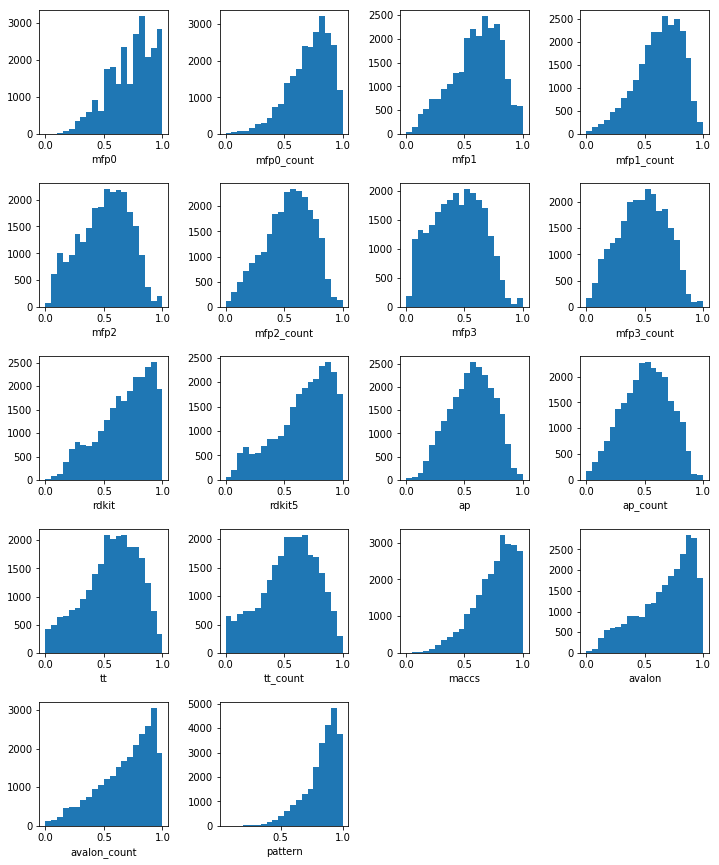

In [19]:
adme_summary = do_summary(adme_sims)
adme_summary

# Tox assays

In [20]:
tox_ic50_data=fetch_data('tox_assays','IC50')
len(tox_ic50_data)

4280

In [21]:
tox_data = [data_tuple(*x) for x in tox_ic50_data]

In [22]:
tox_sims = calculate_sims(tox_data)

Done 1 of 4280
Done 2001 of 4280
Done 4001 of 4280


,fp,0.7,0.8,0.9,0.95,0.99
0,mfp0,0.642857,0.727273,0.833333,0.909091,1.000000
1,mfp0_count,0.605263,0.676471,0.787879,0.861111,0.961538
2,mfp1,0.395833,0.529412,0.677419,0.766667,0.896552
3,mfp1_count,0.432432,0.540541,0.680000,0.758621,0.875000
4,mfp2,0.275000,0.422535,0.593220,0.672727,0.787234
5,mfp2_count,0.314516,0.445652,0.607843,0.684211,0.808824
6,mfp3,0.201923,0.357143,0.536082,0.614286,0.731183
7,mfp3_count,0.246575,0.388430,0.562963,0.637795,0.765625
8,rdkit,0.476461,0.645497,0.746289,0.817964,0.937500
9,rdkit5,0.415954,0.654070,0.773109,0.848837,0.956229


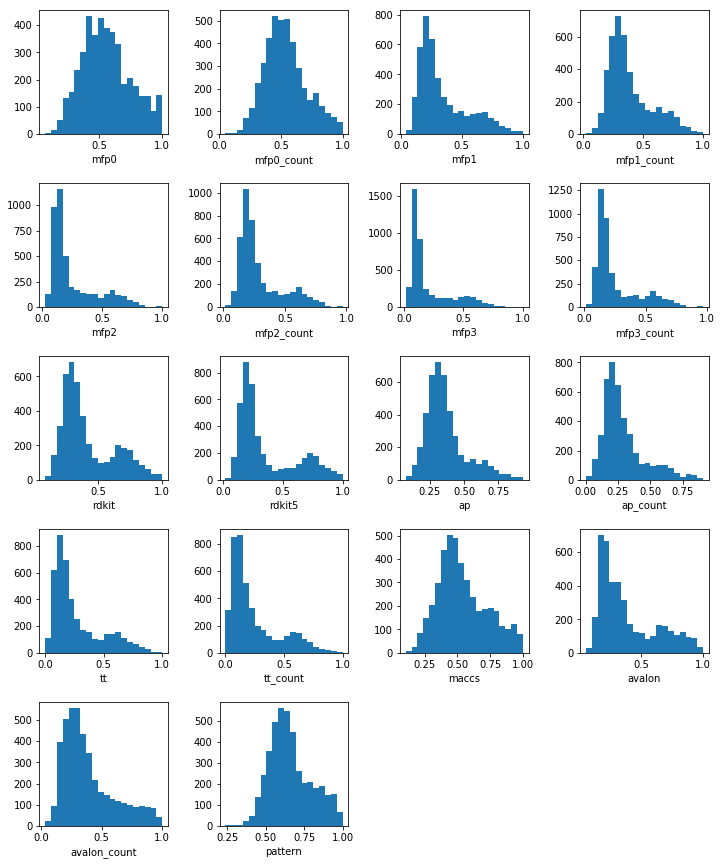

In [23]:
tox_summary = do_summary(tox_sims)
tox_summary

# cellular assays

In [24]:
cellular_ki_data=fetch_data('cellular_assays','Ki')
len(cellular_ki_data)

71094

In [25]:
cellular_cc50_data=fetch_data('cellular_assays','CC50')
len(cellular_cc50_data)

13759

In [26]:
cellular_ac50_data=fetch_data('cellular_assays','AC50')
len(cellular_ac50_data)

17185

In [27]:
cellular_data = [data_tuple(*x) for x in cellular_ki_data+cellular_cc50_data +cellular_ac50_data]

In [28]:
cellular_sims = calculate_sims(cellular_data)

Done 1 of 102038
Done 2001 of 102038
Done 4001 of 102038
Done 6001 of 102038
Done 8001 of 102038
Done 10001 of 102038
Done 12001 of 102038
Done 14001 of 102038
Done 16001 of 102038
Done 18001 of 102038
Done 20001 of 102038
Done 22001 of 102038
Done 24001 of 102038
Done 26001 of 102038
Done 28001 of 102038
Done 30001 of 102038
Done 32001 of 102038
Done 34001 of 102038
Done 36001 of 102038
Done 38001 of 102038
Done 40001 of 102038
Done 42001 of 102038
Done 44001 of 102038
Done 46001 of 102038
Done 48001 of 102038
Done 50001 of 102038
Done 52001 of 102038
Done 54001 of 102038
Done 56001 of 102038
Done 58001 of 102038
Done 60001 of 102038
Done 62001 of 102038
Done 64001 of 102038
Done 66001 of 102038
Done 68001 of 102038
Done 70001 of 102038
Done 72001 of 102038
Done 74001 of 102038
Done 76001 of 102038
Done 78001 of 102038
Done 80001 of 102038
Done 82001 of 102038
Done 84001 of 102038
Done 86001 of 102038
Done 88001 of 102038
Done 90001 of 102038
Done 92001 of 102038
Done 94001 of 102038


,fp,0.7,0.8,0.9,0.95,0.99
0,mfp0,0.846154,0.909091,1.000000,1.000000,1.000000
1,mfp0_count,0.807692,0.852941,0.904762,0.937500,1.000000
2,mfp1,0.717949,0.767123,0.828571,0.875000,0.972973
3,mfp1_count,0.718310,0.769231,0.833333,0.878788,0.947368
4,mfp2,0.636364,0.692308,0.754717,0.803279,0.911765
5,mfp2_count,0.652174,0.708075,0.774390,0.823009,0.913043
6,mfp3,0.579710,0.647059,0.714286,0.762887,0.876404
7,mfp3_count,0.600000,0.666667,0.734375,0.786885,0.884892
8,rdkit,0.822785,0.875989,0.929341,0.960120,0.993118
9,rdkit5,0.794118,0.855330,0.915888,0.952475,0.995662


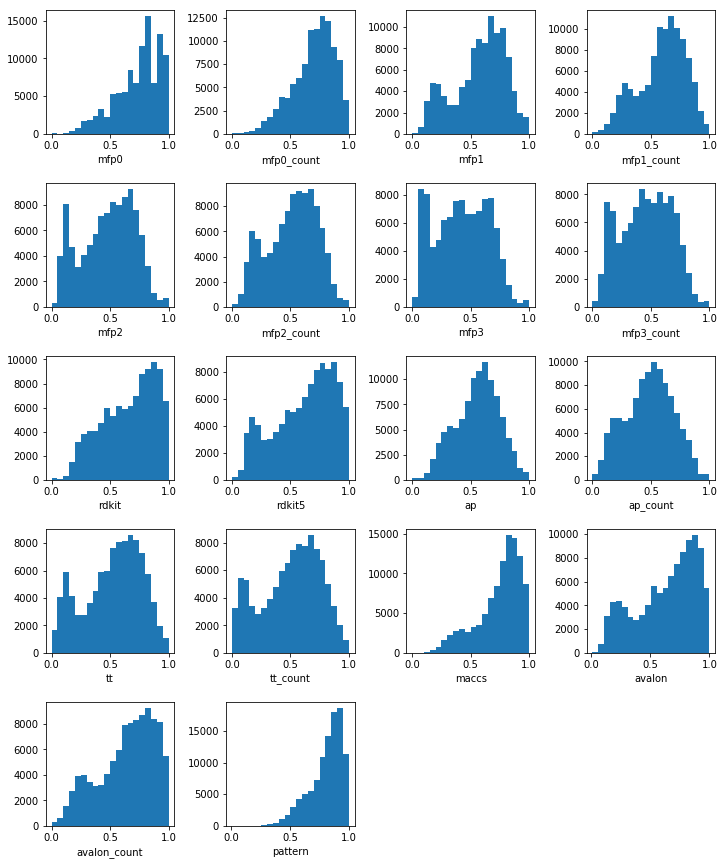

In [29]:
cellular_summary = do_summary(cellular_sims)
cellular_summary

# Tissue assays

In [30]:
tissue_ki_data=fetch_data('tissue_assays','Ki')
len(tissue_ki_data)

6286

In [31]:
tissue_data = [data_tuple(*x) for x in tissue_ki_data]
tissue_sims = calculate_sims(tissue_data)

Done 1 of 6286
Done 2001 of 6286
Done 4001 of 6286
Done 6001 of 6286


,fp,0.7,0.8,0.9,0.95,0.99
0,mfp0,0.857143,0.909091,1.000000,1.000000,1.000000
1,mfp0_count,0.825000,0.866667,0.911765,0.947368,1.000000
2,mfp1,0.709677,0.763158,0.833333,0.883721,1.000000
3,mfp1_count,0.720000,0.777778,0.846154,0.887640,0.968750
4,mfp2,0.607143,0.672131,0.750000,0.819444,0.977273
5,mfp2_count,0.631579,0.698630,0.775510,0.833333,0.953125
6,mfp3,0.540230,0.603448,0.694030,0.773810,0.936937
7,mfp3_count,0.569106,0.636364,0.727273,0.793750,0.924051
8,rdkit,0.831444,0.886503,0.943363,0.972553,0.998252
9,rdkit5,0.810875,0.871542,0.927739,0.962838,1.000000


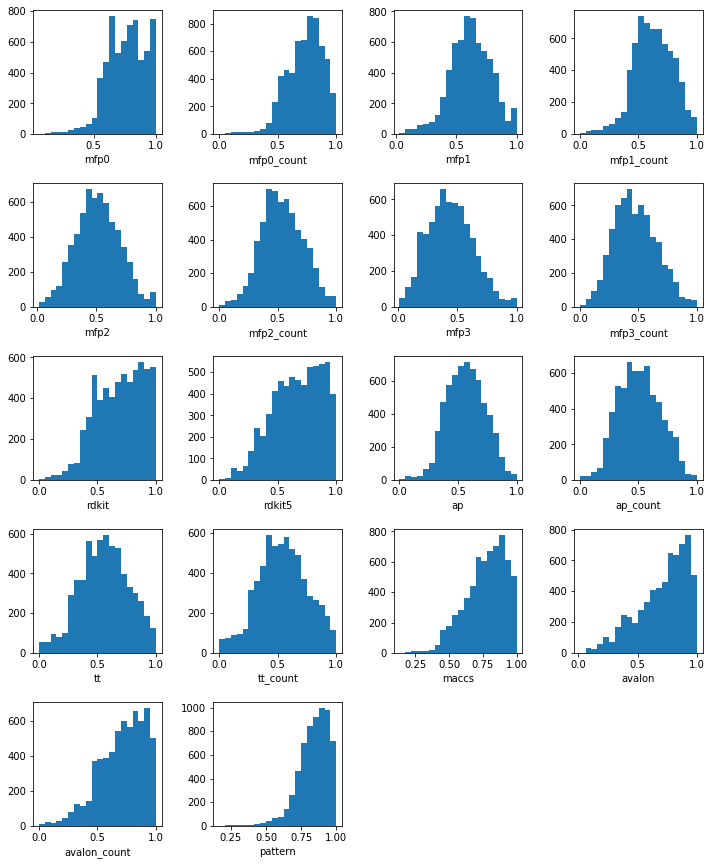

In [32]:
tissue_summary = do_summary(tissue_sims)
tissue_summary

# Put everything together:

,fp,0.7,0.8,0.9,0.95,0.99
0,mfp0,0.846154,0.909091,1.000000,1.000000,1.000000
1,mfp0_count,0.810811,0.857143,0.906250,0.939394,1.000000
2,mfp1,0.714286,0.766667,0.829268,0.878788,1.000000
3,mfp1_count,0.720430,0.772152,0.837209,0.880000,0.950000
4,mfp2,0.631579,0.689655,0.755102,0.804878,0.915663
5,mfp2_count,0.649123,0.707547,0.775701,0.824176,0.914286
6,mfp3,0.571429,0.640449,0.711712,0.763158,0.876923
7,mfp3_count,0.594771,0.664122,0.733766,0.786885,0.884058
8,rdkit,0.821313,0.876128,0.930091,0.961147,0.993595
9,rdkit5,0.797071,0.858316,0.918429,0.954545,0.996497


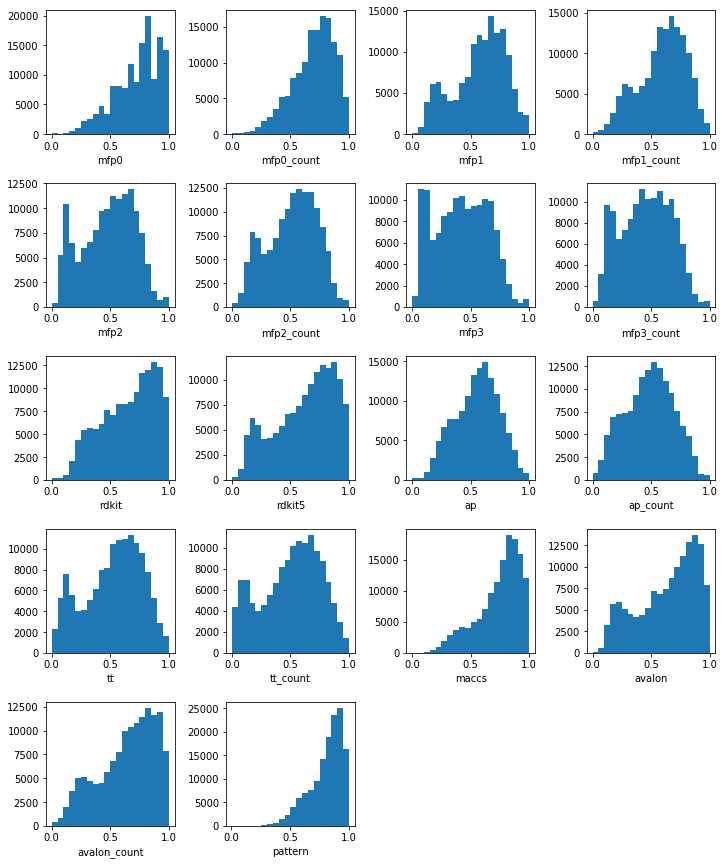

In [33]:
all_sims = adme_sims + tox_sims + cellular_sims + tissue_sims
all_summary = do_summary(all_sims)
all_summary